# ASTR 596: The Final

#### Three questions, each worth a third of your grade. (I'll make one 34 pts to get to an even 100). Each is designed to test an area where I think the class as a whole is less comfortable. They are sorted by my assesment of difficulty from easiest to hardest. 
#### i.e. the last is probably going to be non-trivial, because well I like Gaussian distributions of grades. 
#### That's OK because the points and grades don't matter!

#### Remember, you can work together, discuss problems and solutions, but you have to write up your own solution. I'd strongly suggest doing that, ideally with some divide and conquer strategy.

### Q1. Using unsupervised learning to work with galaxies

The following query will select 20k likely galaxies from the SDSS database and return the results of that query into an `astropy Table`.  (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

In [22]:
%matplotlib inline
#%pylab
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

from astropy.table import Table
import numpy as np
from astropy.stats import sigma_clip
from tqdm import tqdm


#Parallelization
import os
import multiprocess as mp
os.environ["OMP_NUM_THREADS"] = "1"

GALquery = """SELECT TOP 20000 
         p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
         p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
         p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
         FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
         WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
         AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
           """
SDSSgals = SDSS.query_sql(GALquery)
SDSSgals

ug,gr,gi,gz,petroRad_i,petroR50_i,deVAB_i,fracDev_i
float64,float64,float64,float64,float64,float64,float64,float64
1.999718,0.9592915,1.370582,1.692535,5.454633,2.344662,0.8708095,1.0
1.98884,0.9332962,1.361919,1.668918,5.177937,2.424093,0.9946066,0.8865207
1.020407,1.601521,2.396175,2.827263,5.846272,1.158836,0.6898293,1.0
1.83742,1.211882,1.688545,1.989878,7.145427,2.795447,0.7493948,1.0
4.55904,1.536175,2.29286,2.712597,4.741546,2.09032,0.5173162,0.8244159
4.532835,1.433081,2.251518,2.669952,8.930706,1.656738,0.6116931,1.0
2.075247,1.267462,1.746914,2.053957,5.091534,2.249913,0.6196061,1.0
1.677757,1.102043,1.582317,1.902397,6.5472,2.809995,0.8713289,0.9118057
1.858603,0.9054127,1.364218,1.661177,6.641626,2.84336,0.4171,1.0


### 1a - Visualize the dataset in g-i (y) vs u-g (x) and all the features (11 pts). 

The bluest galaxies are star-forming galaxies at low redshift 𝑧. The "tight" cluster of red galaxies are passive galaxies at low-𝑧. Finally the diffuse cloud at 𝑔−𝑖≈3 are high-𝑧 luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of 𝑢−𝑔 colors because they essentially are not detected in the 𝑢 band as this is blueward of the Lyman break.

Plot and examine each of the features in this data set using seaborn's `PairGrid`. Overlay a histogram and kernel density distribution (KDE) on each 1D and 2D plot. You should be able to roughly see the different groups of galaxies, but how to separate them?

In [3]:
#Get rid of NaNs
mask_tot = np.full( len(SDSSgals), True, dtype=bool )
for col in SDSSgals.colnames:
    mask = np.isfinite(SDSSgals[col].tolist())
    mask_tot = mask_tot & mask
    
    
#Get rid of bad color values
for col in ['ug', 'gr', 'gi', 'gz']:
    mask = np.array(SDSSgals[col]) > -10
    mask_tot = mask_tot & mask
    
#Sigma clip for outliers (> 5sigma)
for col in SDSSgals.colnames:
    mask = sigma_clip( SDSSgals[col].tolist(), sigma=5 )
    mask_tot = mask_tot & (~mask.mask)

    
SDSSgals = SDSSgals[mask_tot]

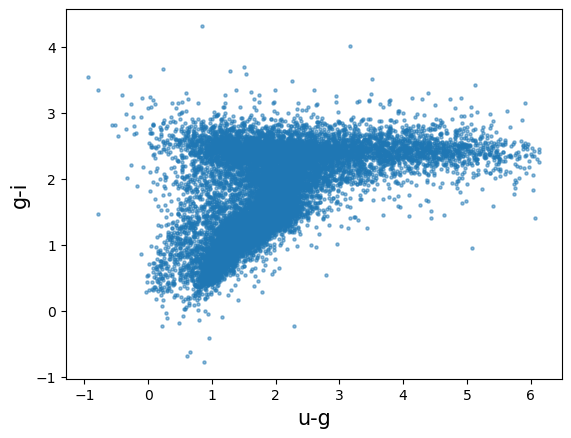

In [6]:
plt.scatter(SDSSgals['ug'], SDSSgals['gi'], s=5, alpha=.5)
plt.xlabel('u-g', fontsize=15)
plt.ylabel('g-i', fontsize=15)
plt.show()

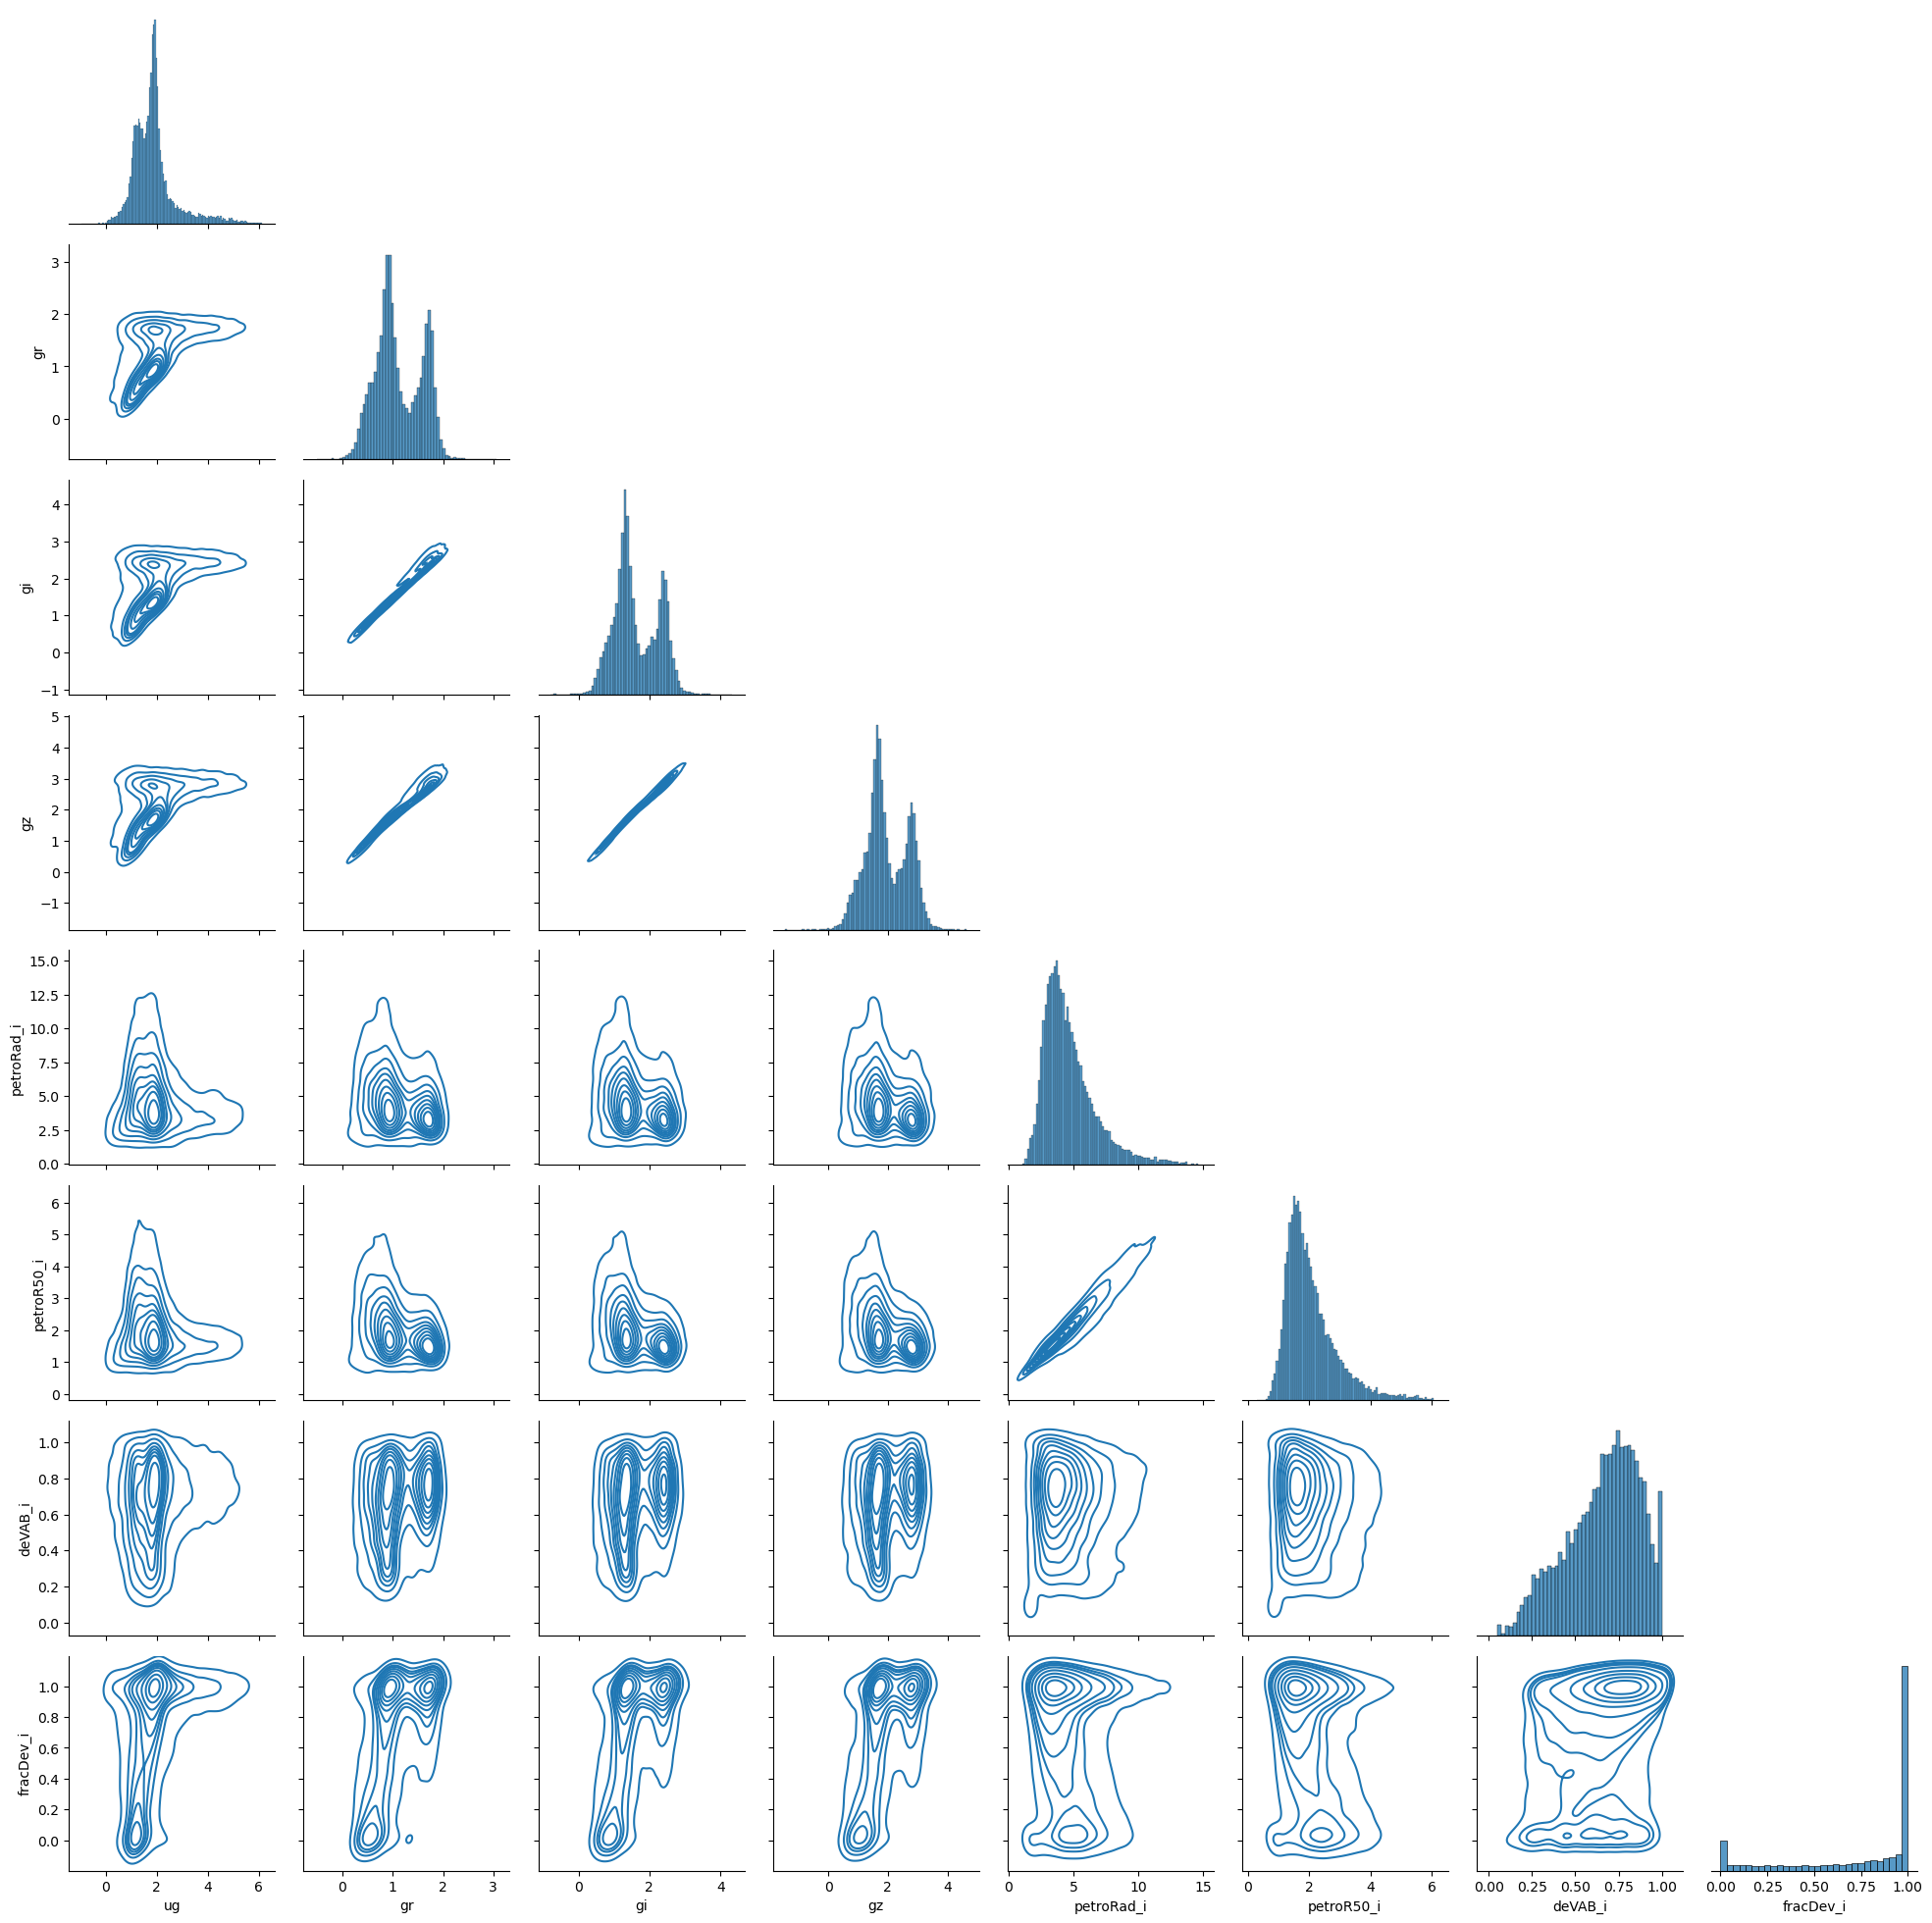

In [7]:
import seaborn as sns

pg = sns.PairGrid(SDSSgals.to_pandas(), diag_sharey=False, corner=True)
pg.map_lower(sns.kdeplot)
pg.map_diag(sns.histplot)

### 1b - Separating the galaxy types (11 pts) 

Using K-means from `sklearn` with n=3, separate the three clusters of galaxies. Initial guesses, hyper-paramter tuning, dimensionality reduction etc are your choices. What's important is to be able to justify them. To the referee, to me, to yourself. We'll do that in the next part. 

In [8]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 3
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(SDSSgals.to_pandas()))

/Users/stoz1/anaconda3/envs/fds2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

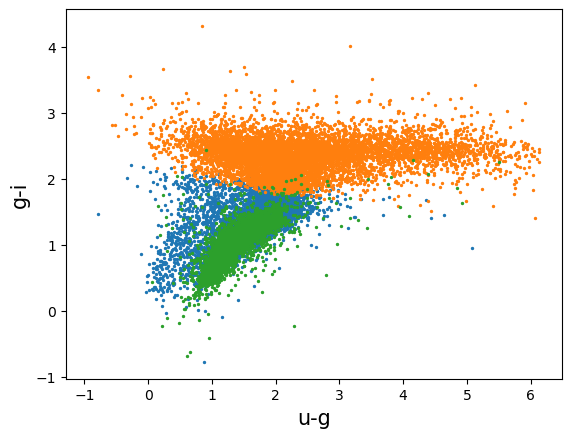

In [10]:
labels1 = clf.labels_
labels_unique = sorted(np.unique(labels1))

for i in range(len(labels_unique)):
    mask = (labels1 == labels_unique[i])

    plt.scatter( SDSSgals['ug'][mask], SDSSgals['gi'][mask], s=2)
plt.xlabel('u-g', fontsize=15)
plt.ylabel('g-i', fontsize=15)
plt.show()

### 1c - Working with the distributions (11 pts)
Repeat 1a, but using the results of K-means in 1b to create separately colored distributions for your different classes of galaxies. Use the KDE to provide the mean values of each feature and their standard deviation (hint - these are integrals), and compare them to the sample means and standard deviations. 

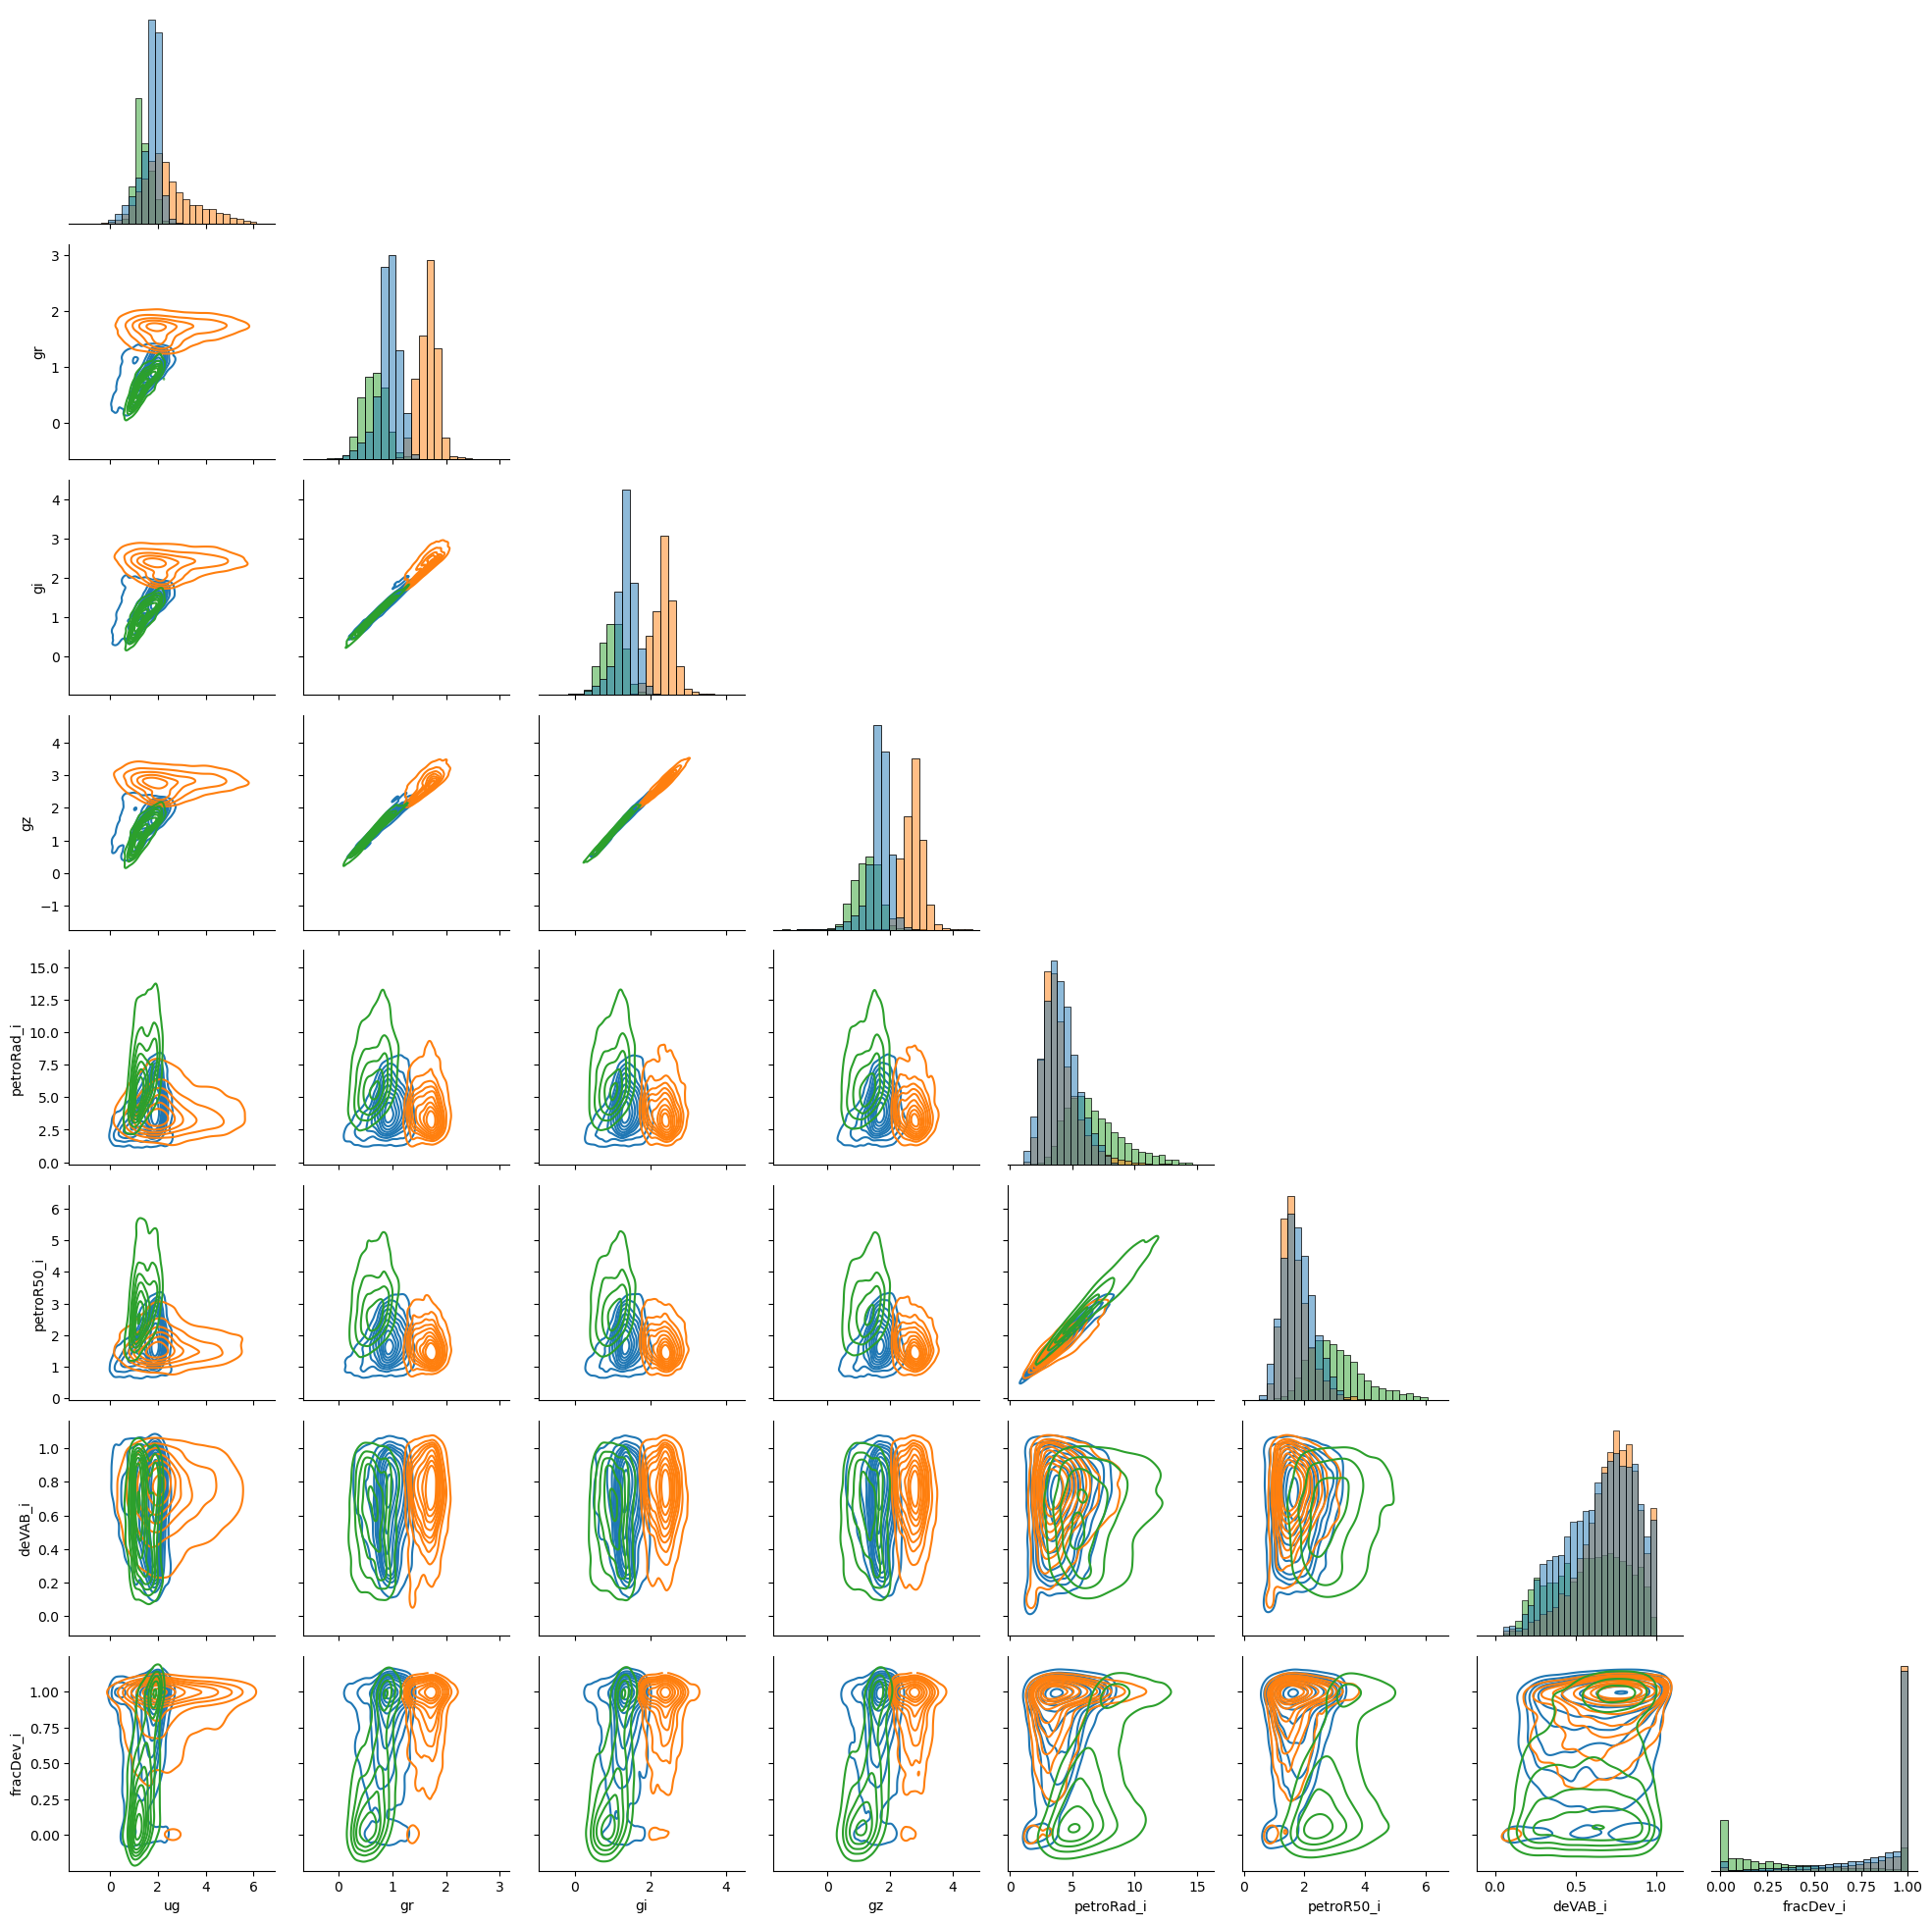

In [11]:
#Add labels to table
SDSSgals['labels'] = labels1

#Plot
pg = sns.PairGrid(SDSSgals.to_pandas(), diag_sharey=False, corner=True, hue='labels', palette='tab10')
pg.map_lower(sns.kdeplot)
pg.map_diag(sns.histplot, bins=25, lw=1.5)

In [12]:
labels_tab = []
cols_tab = []
means_tab = []
std_tab = []

for col in SDSSgals.colnames[:-1]:
    for label in labels_unique:
        
        mask = (labels1 == label)
        x = np.array(SDSSgals[col][mask])
        
        ax = sns.kdeplot(x);
        kdeline = ax.lines[0]

        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        
        mean = np.trapz(xs*ys, x=xs)
        std = np.trapz( (xs - mean)**2 * ys, x=xs )
        
        plt.cla()
        plt.clf()
        plt.close()
        
        
        labels_tab.append( label )
        cols_tab.append(col)
        means_tab.append(mean)
        std_tab.append(std)


summary_table = Table()
summary_table['labels'] = labels_tab
summary_table['cols'] = cols_tab
summary_table['mean'] = means_tab
summary_table['std'] = std_tab

In [13]:
means_tot = []
stds_tot = []
for col in SDSSgals.colnames[:-1]:
    means_tot.append( np.mean(SDSSgals[col].tolist()) )
    stds_tot.append( np.std(SDSSgals[col].tolist()) )  
    

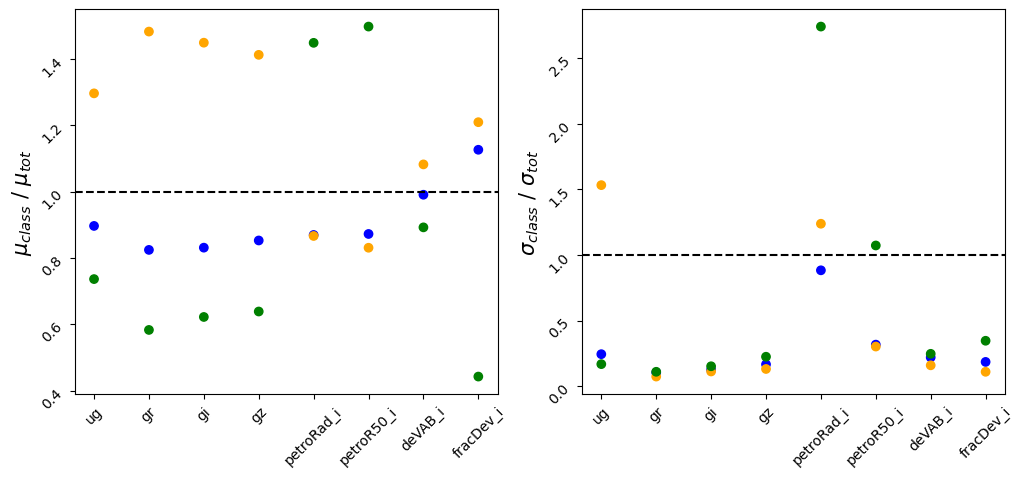

In [14]:
colors = ['b', 'orange', 'g']
fig,ax = plt.subplots(1, 2, figsize=(12,5))

for i, col in enumerate(SDSSgals.colnames[:-1]):
    mask = summary_table['cols'] == col
    
    means_label = []
    stds_label = []
    
    for j in range(len(labels_unique)):
        ind = np.argwhere( summary_table[mask]['labels'] == labels_unique[j] ).T[0][0]
        
        mean_i = summary_table['mean'][mask][ind]
        std_i = summary_table['std'][mask][ind]
        
        means_label.append( mean_i/means_tot[i] )
        stds_label.append( std_i/stds_tot[i] )
        
    ax[0].scatter( np.full( 3, i ), means_label, color=colors )
    ax[1].scatter( np.full( 3, i ), stds_label, color=colors )
        
        
ax[0].set_ylabel(r'$\mu_{class} \ / \ \mu_{tot}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{class} \ / \ \sigma_{tot}$', fontsize=15)


for a in ax:
    a.set_xticks( range(len(SDSSgals.colnames[:-1])) )
    a.set_xticklabels(SDSSgals.colnames[:-1])
    a.tick_params( rotation=45 )
    
    a.axhline(1, ls='--', color='k')
            
plt.show()
        

__Zach__: $\mu_{class}$ is the mean for the quantity on the x-axis for that class (shown by the color), and $\mu_{tot}$ is the mean for the whole quantity, for all objects. The standard deviation $\sigma$ is defined similarly. The black dashed line shows where the two are equal.

### Q2. Gaussian Processes + Emcee

There are many sources with periodic light curves that are not strictly sinusoidal. Thus, the use of the cosine kernel (on its own) may not be sufficient to model the signal. The quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = A \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

is useful for non-sinusoidal signals. It is implemented in the `george` package. Note that the parameters in the kernel aren't the only parameters you might need... look back on your previous homework assignments and think about what I'm glossing over here. 

I've given you an example light curve file with a decidedly non-sinusoidal, periodic signal from the ASAS-SN project from our colleagues at OSU. 

### 2a - Implement the model  (11 pts)

Examine this data, filter it as you see fit (I've included the file header in full - I'd pick one aperture, and look at the grades and notes about separate datasets). You can make tradeoffs here - more data that is potentially messier, vs less data so weaker constraints, but cleaner. Pick something that you can justify (and if you're struggling at 2c, examine this choice before twiddling with emcee). 

Write down a model for it with the likelihood function, an appropriate prior and posterior.

You may wish to look at the `george` documentation again, particularly how some parameters are better log transformed if the expectation is that they are positive real values. 

https://george.readthedocs.io/en/latest/tutorials/model/

In [23]:
q2_dat = Table.read('asas_data.dat', format='ascii', names=['HJD', 'MAG_1', 'MAG_0', 'MAG_2', 'MAG_3', 'MAG_4', 'MER_1', 'MER_0', 'MER_2', 'MER_3', 'MER_4', 'GRADE', 'FRAME'])
q2_dat.sort('HJD')

In [24]:
#Only keep GRADE = A,B
mask = (q2_dat['GRADE'] == 'A') | (q2_dat['GRADE'] == 'B')
q2_dat = q2_dat[mask]

#Remove mags > 20
mask = np.full(len(q2_dat), True)
for col in ['MAG_'+str(x) for x in range(5)]:
    mask_i = q2_dat[col] < 20
    mask = mask & mask_i
    
q2_dat = q2_dat[mask]


#Use the mean of all apertures (and the corresponding error)
xdat = np.array(q2_dat['HJD'])
ydat = np.array( q2_dat[['MAG_'+str(x) for x in range(5)]].to_pandas() ).mean(1)
yerrdat = np.sqrt(np.sum(np.array(q2_dat[['MER_'+str(x) for x in range(5)]].to_pandas() )**2, axis=1))

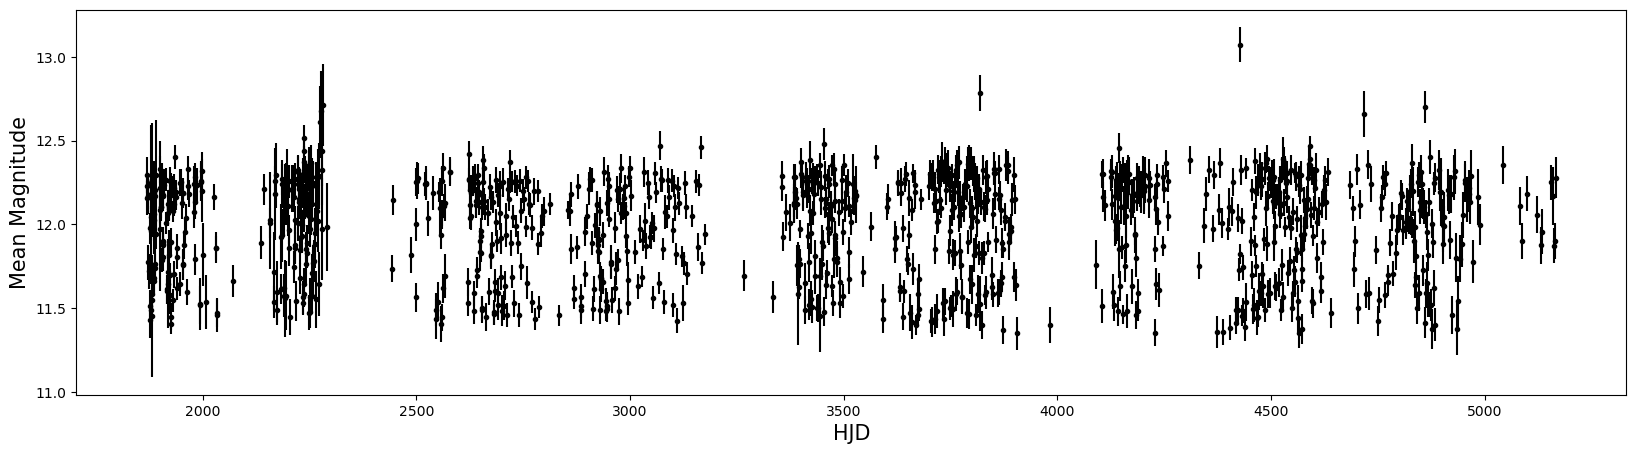

In [25]:
fig, ax = plt.subplots( figsize=(20, 5) )
ax.errorbar(xdat, ydat, yerrdat, fmt='.k')
ax.set_xlabel('HJD', fontsize=15)
ax.set_ylabel('Mean Magnitude', fontsize=15)
plt.show()

In [26]:
from george import kernels


#Get kernel object
def get_kernel(A, Gamma1, P, bounds):

    bounds_i = np.log(bounds[0])
    kernel0 = kernels.ConstantKernel(log_constant=np.log(A), bounds=[bounds_i] )

    bounds_i = np.log(bounds[2])
    kernel1 = kernels.ExpSine2Kernel(gamma=Gamma1, log_period=np.log(P), bounds=[bounds[1], bounds_i])

    kernel = kernels.Product(kernel0, kernel1)
    return kernel

In [27]:
from george import GP


#Get GP object
def get_GP(bounds):

    A = np.mean(bounds[0])
    Gamma1 = np.mean(bounds[1])
    P = np.mean(bounds[2])

    kernel = get_kernel(A, Gamma1, P, bounds)
    gp = GP(kernel, fit_mean=True)

    return gp


#Get prior bounds
def get_bounds():

    A_bounds = (.05, 500)
    Gamma_bounds = (-1000, 5000)
    P_bounds = (1e-5, 1e3)

    return [A_bounds, Gamma_bounds, P_bounds]



bounds_tot = get_bounds()

gp = get_GP(bounds_tot)
gp.compute( xdat, yerrdat )

def log_posterior(params):
    gp.set_parameter_vector(params)
    return gp.log_likelihood( np.array(ydat), quiet=True) + gp.log_prior()

### 2b - Initial Guesses (11 pts)

Make some initial guess for the parameters. For the period, use Lomb-Scargle to find the top three periods for this light curve. Initialize 1/3rd of the walkers to each of the top three periods

Do the burn in with `emcee` - a 100 walkers and a 1000 steps should be plenty - you should find that the walkers have migrated away from the starting guess. Plot the chains. 

Make a plot of the log of the Posterior vs the log of the Period - select the periods with the highest log Posterior and change the initial guess for the Period of all the walkers to be in a small region around the Period with the highest log Posterior. 

In [160]:
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle

#Make Lomb-Scargle periodogram
freq_min = 1/( xdat.max() - xdat.min() )
freqs, power = LombScargle(xdat, ydat, yerrdat).autopower(minimum_frequency=freq_min, maximum_frequency=100)


#Find peaks
peaks, _ = find_peaks( np.log10(power), distance=100)
period_peaks = 1/freqs[peaks]

#Sort by period
sort_ind = np.argsort(period_peaks)
peaks = peaks[sort_ind]
period_peaks = period_peaks[sort_ind]


#Get rid of peaks that are multiples
fracs = range(2, 5)
tol = .001
bad_ind = []
for i in tqdm( range(len(period_peaks)) ):
    if i in bad_ind:
        continue
    
    for f in fracs:
        mask = np.abs( period_peaks[i]*f - period_peaks) < tol
        ind = np.argwhere( mask ).T[0]
        
        if len(ind) > 0:
            bad_ind = np.hstack([bad_ind, ind])
            bad_ind = np.unique(bad_ind)

bad_ind = bad_ind.astype(int)          

#Remove multiples
peaks = np.delete(peaks, bad_ind)
period_peaks = np.delete(period_peaks, bad_ind)

#Sort by power
sort_ind = np.argsort( power[peaks] )[::-1]
peaks = peaks[sort_ind]
period_peaks = period_peaks[sort_ind]

100%|██████████| 12129/12129 [00:01<00:00, 7596.06it/s] 


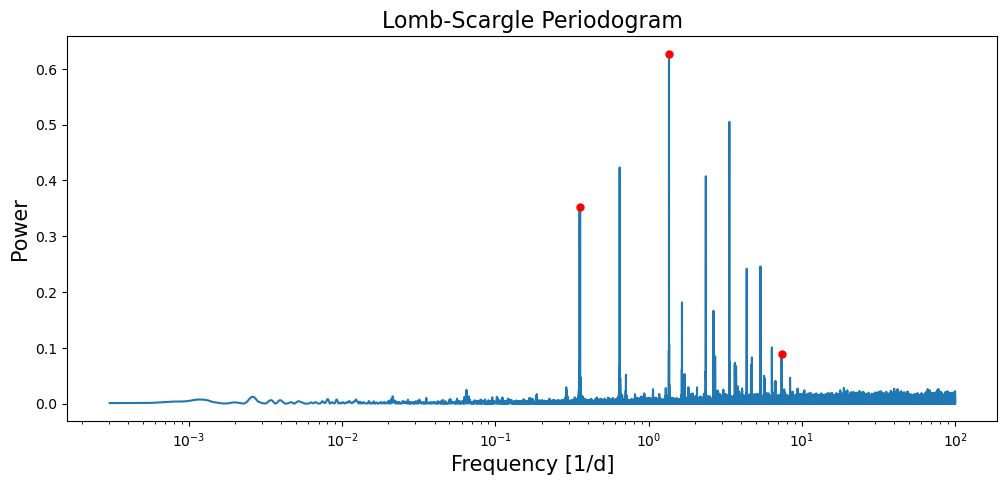

In [161]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(freqs, power)
for i in range(3):
    ax.plot([1/period_peaks[i]], [power[peaks[i]]], marker='.', color='r', ms=10)
    
ax.set_xscale('log')


plt.xlabel('Frequency [1/d]', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.title('Lomb-Scargle Periodogram', fontsize=16)

plt.show()

In [164]:
period_peaks[:3]

array([0.73711053, 2.80392785, 0.13578192])

In [165]:
import emcee

#Get initial guesses
#  * A = 1
#  * Gamma1 = 0
#  * P = (top three peaks)
def get_initial(nwalkers, P_peaks):

    A_init = np.ones( nwalkers, dtype=float )    
    P_init = []
    
    if (nwalkers//len(P_peaks)) * len(P_peaks) == nwalkers:
        len_i = np.full( len(P_peaks), nwalkers//len(P_peaks), dtype=int )
    else:
        len_i = np.zeros( len(P_peaks), dtype=int )
        len_i[:len(P_peaks)-1] = int(  nwalkers//len(P_peaks) )
        len_i[-1] = int(  nwalkers - (nwalkers//len(P_peaks))*( len(P_peaks)-1 )  )
    
    for i in range(len(P_peaks)):
        P_init.append( np.full(len_i[i], P_peaks[i]) )


    P_init = np.hstack(P_init)


    Gamma_init = np.zeros(nwalkers)

    return np.vstack([ np.log(A_init), Gamma_init, np.log(P_init) ]).T


ndim = 3
nwalkers = 100
nburn = 1000


#Run MCMC burn-in
initial = get_initial(nwalkers, period_peaks[:3])
p0 = initial + (1e-8)*np.random.randn(nwalkers, ndim)

#Speed up with multiprocess(ing)
pool = mp.Pool(50)
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior, pool=pool )
_ = sampler.run_mcmc(p0, nburn, progress=True)

100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


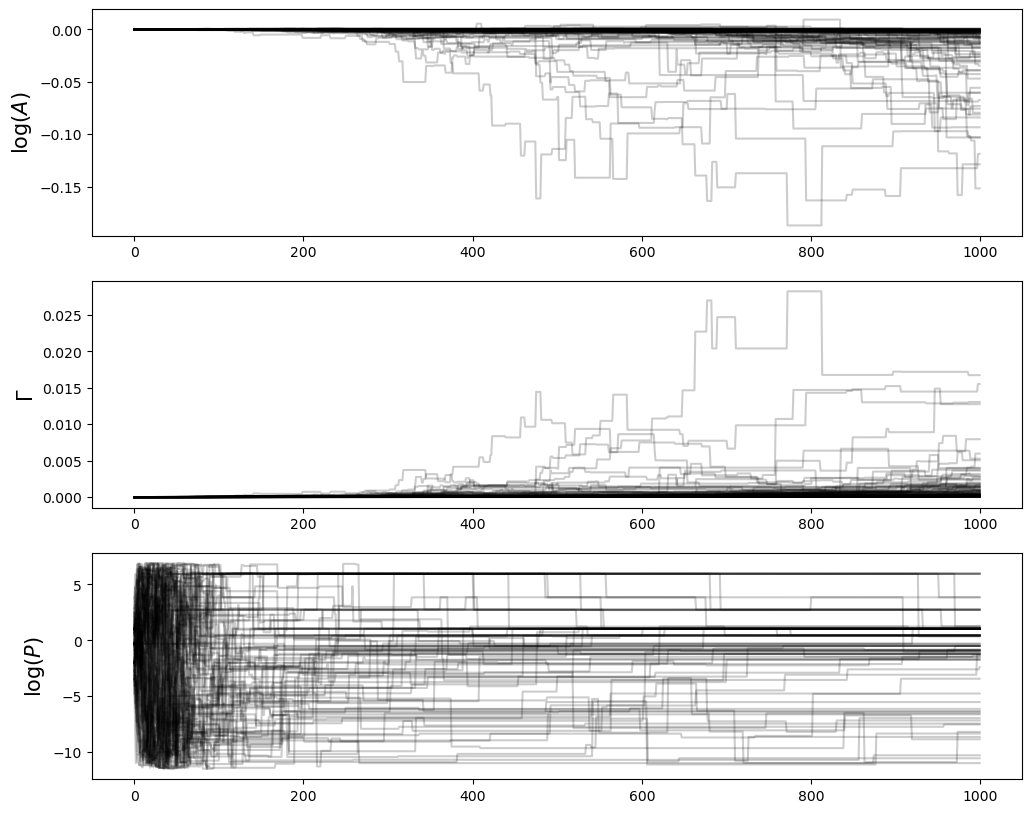

In [166]:
#Plot chains
samples_full0 = sampler.get_chain()
samples_flat0 = sampler.get_chain(flat=True)


fig, ax = plt.subplots(samples_full0.shape[2], figsize=(12, 10))

for i in range(samples_full0.shape[2]):
    for j in range(samples_full0.shape[1]):
        
        ax[i].plot(samples_full0[:,j,i], color='k', alpha=.2)
        

ax[0].set_ylabel(r'$\log(A)$', fontsize=15)
ax[1].set_ylabel(r'$\Gamma$', fontsize=15)
ax[2].set_ylabel(r'$\log(P)$', fontsize=15)
        
plt.show()

/var/folders/k5/py9k93g561scrs7x0lhj8nv40000gn/T/ipykernel_72309/979331292.py:13: RuntimeWarning: divide by zero encountered in log10
  mask = ~np.isfinite( np.log10(hist) )


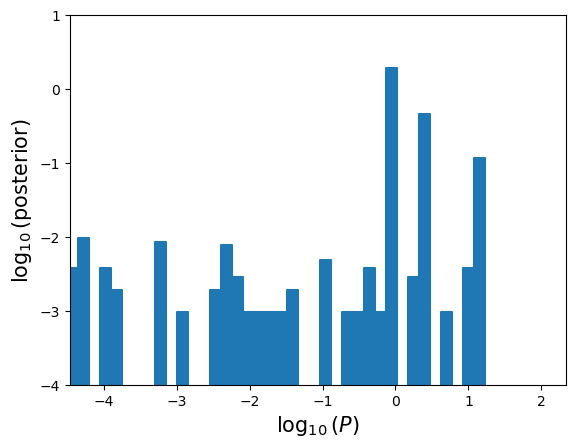

In [169]:
#Get binned posterior
hist, bin_edges = np.histogram(samples_full0[:,2], 50, density=True)  


bin_centers = []
for i in range(len(bin_edges)-1):
    bin_centers.append( (bin_edges[i+1] + bin_edges[i])/2 )
    
bin_centers = np.log10(np.exp(bin_centers))
bin_edges = np.log10(np.exp(bin_edges))  

  
mask = ~np.isfinite( np.log10(hist) )
hist[mask] = 1e-100

#Plot log(posterior)-log(P)
plt.plot( bin_centers, np.log10(hist), ds='steps-mid' )
plt.fill_between( bin_centers, -10, np.log10(hist), step='mid')
plt.ylabel(r'$\log_{10}(\rm posterior)$', fontsize=15)
plt.xlabel(r'$\log_{10}(P)$', fontsize=15)
plt.ylim(-4, 1)
plt.xlim(bin_edges[0]*.9, bin_edges[-1]*.9)
plt.show()

In [170]:
sort_ind = np.argsort(hist)[::-1]
best_period = 10**(bin_centers[sort_ind[0]])
best_period

0.890165840392054

In [171]:
#Run full MCMC
nchain = 4000

initial2 = get_initial(nwalkers, [best_period])
p02 = initial2 + (1e-8)*np.random.randn(nwalkers, ndim)

sampler.reset()
_ = sampler.run_mcmc(p02, nchain, progress=True)
pool.close()
pool.join()

100%|██████████| 4000/4000 [24:44<00:00,  2.70it/s]


### 2c - Infer the model parameters (11 pts)

Plot the chains, the corner plot, the folded lightcurve, the Gaussian process model given the median parameters, 10 other draws from the model and the uncertainty about the model. 


In [172]:
#From the trace plots, looks like I should skim an additional 2000 steps

samples_full = sampler.get_chain()
samples_flat = sampler.get_chain(flat=True, discard=2000)

np.savez_compressed( 'Problem2_samples', samples_full )

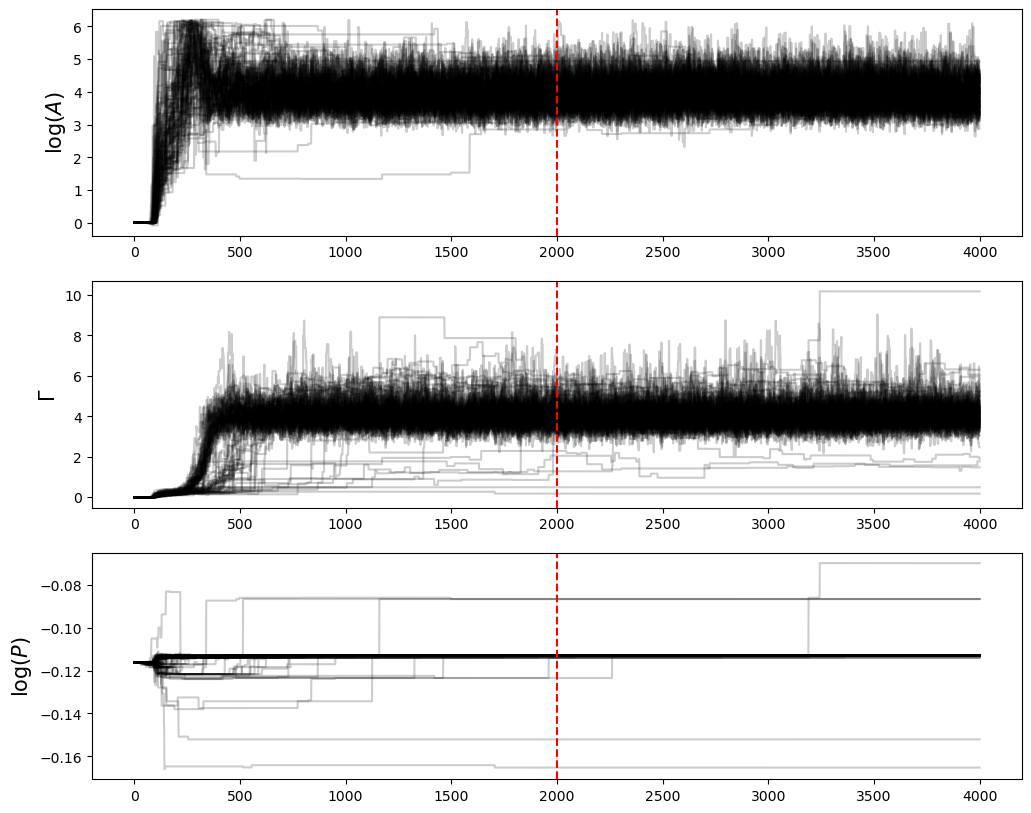

In [173]:
##############
#Trace plot

fig, ax = plt.subplots(samples_full.shape[2], figsize=(12, 10))

for i in range(samples_full.shape[2]):
    for j in range(samples_full.shape[1]):
        ax[i].plot(samples_full[:,j,i], color='k', alpha=.2)

    ax[i].axvline(2000, ls='--', color='r')

ax[0].set_ylabel(r'$\log(A)$', fontsize=15)
ax[1].set_ylabel(r'$\Gamma$', fontsize=15)
ax[2].set_ylabel(r'$\log(P)$', fontsize=15)

plt.show()

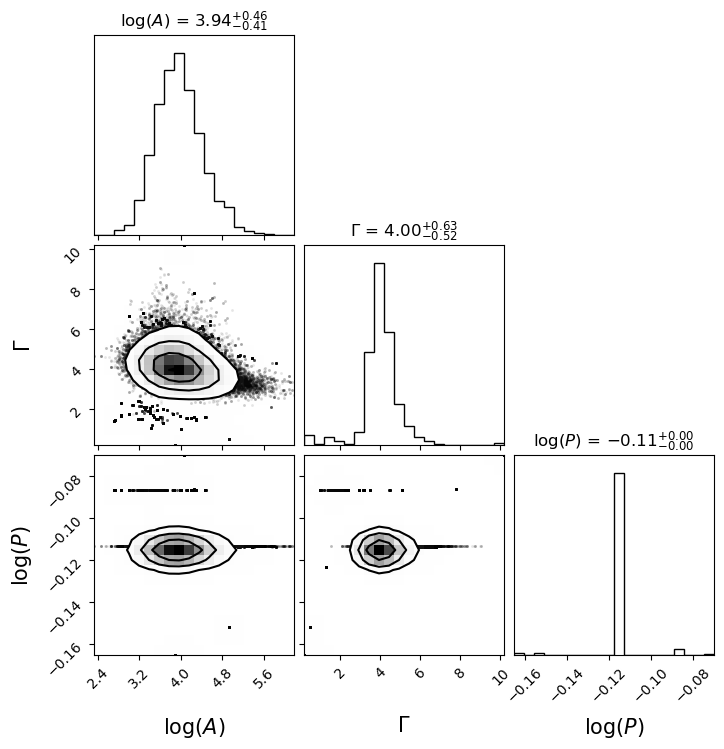

In [174]:
##############
#Corner plot

import corner

labels = [r'$\log(A)$', r'$\Gamma$', r'$\log(P)$']
corner.corner(samples_flat, labels=labels, show_titles=True, smooth=1, label_kwargs={"fontsize": 15});
plt.show()

In [175]:
med_params = np.median( samples_flat, axis=0 )

100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


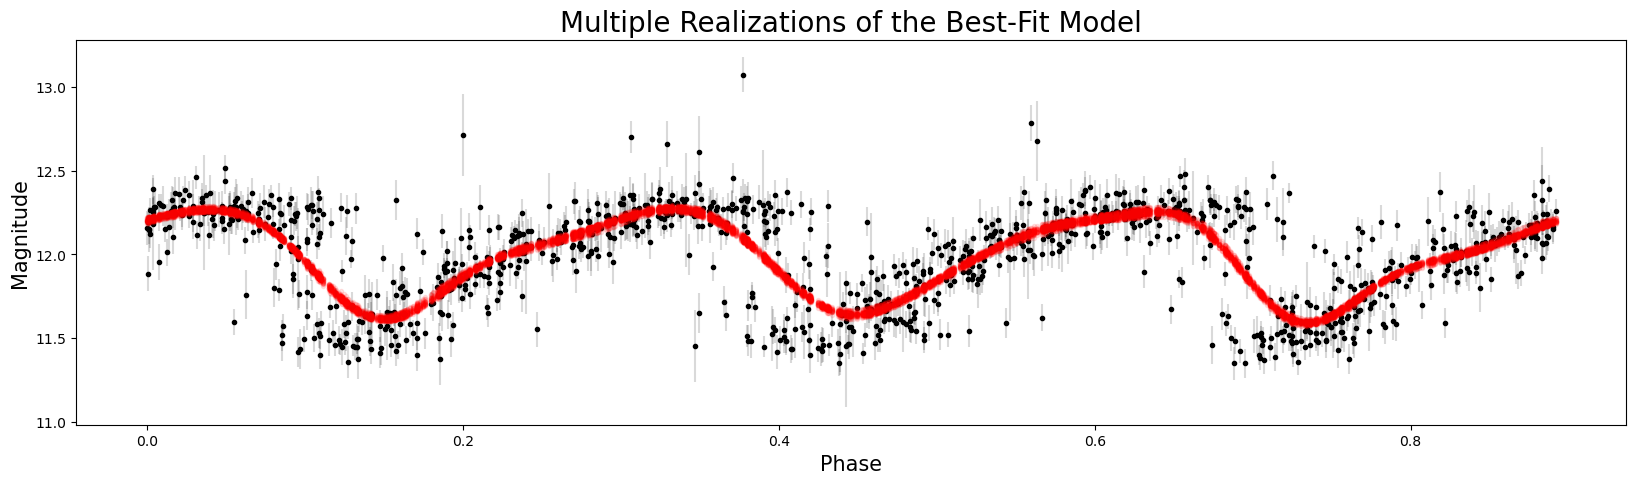

In [176]:
##############
#Predictions

from tqdm import tqdm

fig, ax = plt.subplots(figsize=(20,5))

times = ( xdat - xdat.min() ) % np.exp( med_params[2] )

lines, caps, bars = ax.errorbar( times, ydat, yerrdat, fmt='.k' )
[bar.set_alpha(.15) for bar in bars]

for s in tqdm(samples_flat[::10000]):
    gp.set_parameter_vector(s)
    
    mu = gp.sample_conditional( np.array(ydat), np.array(xdat) )
    ax.plot( times, mu, color='r', alpha=.1, lw=0, zorder=1000, marker='.' )

ax.set_ylabel('Magnitude', fontsize=15)
ax.set_xlabel('Phase', fontsize=15)
ax.set_title('Multiple Realizations of the Best-Fit Model', fontsize=20)

plt.show()

In [177]:
##############
#Draw from the model

ndraw = 10
tdraw = np.linspace(xdat.min(), xdat.max(), 5000) 

gp.set_parameter_vector(med_params)
samples = gp.sample(tdraw, ndraw)

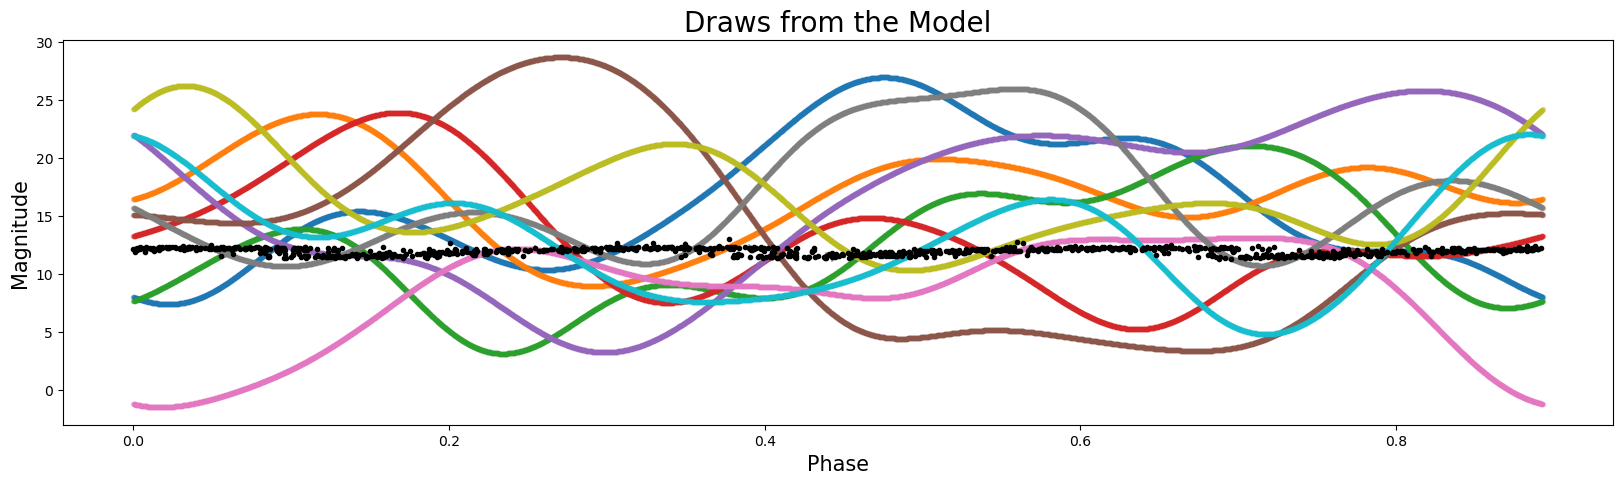

In [178]:
times_draw = ( tdraw - xdat.min() ) % np.exp( med_params[2] )

fig, ax = plt.subplots(figsize=(20,5))

lines, caps, bars = ax.errorbar( times, ydat, yerrdat, fmt='.k' )
[bar.set_alpha(.3) for bar in bars]

for i in range(len(samples)):   
    ax.plot(times_draw, samples[i] + ydat.mean(), lw=0, alpha=.3, marker='.')
    
ax.set_xlabel('Phase', fontsize=15)
ax.set_ylabel('Magnitude', fontsize=15)
    
ax.set_title('Draws from the Model', fontsize=20)

plt.show()

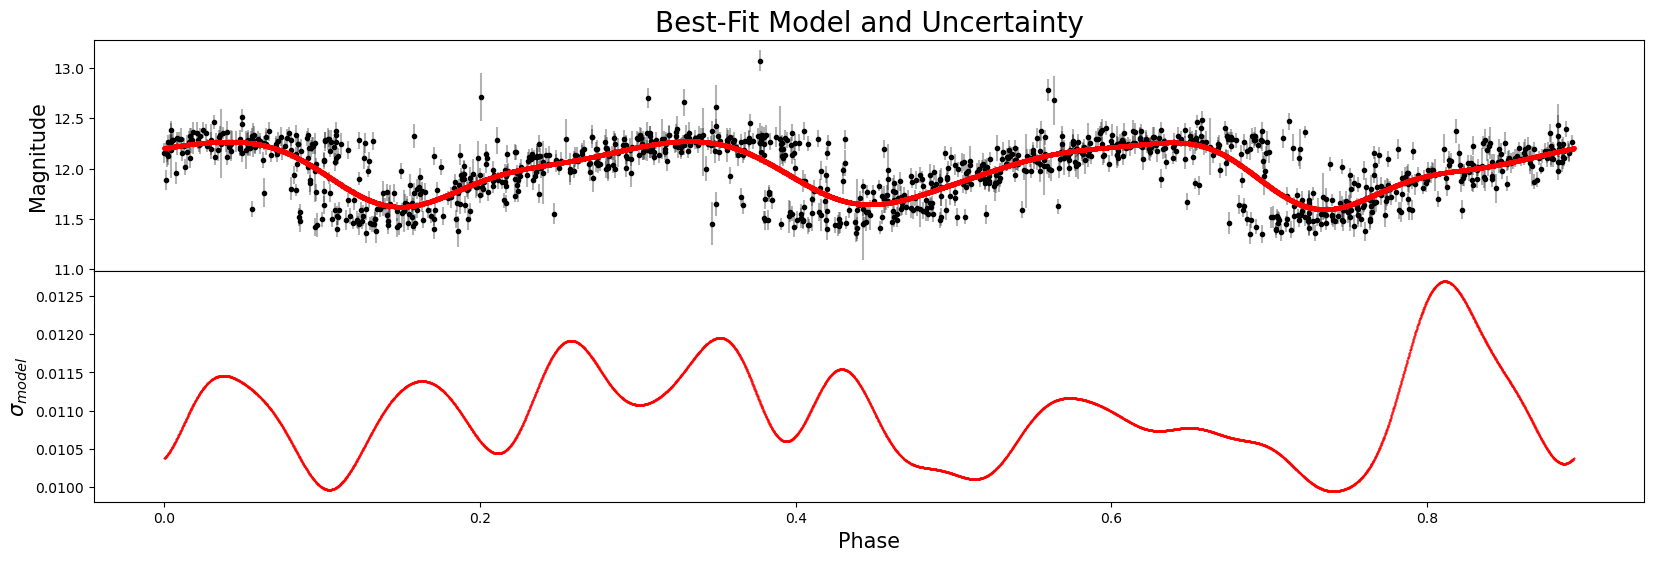

In [180]:
##############
#Predict and get uncertainty
xpred = np.linspace(xdat.min(), xdat.max(), 5000)
mu, var = gp.predict(ydat, xpred, return_var=True)
std = np.sqrt(var)

times_pred = (xpred - xdat.min()) % np.exp(med_params[2])



fig, ax = plt.subplots(2, figsize=(20,6), sharex=True)

lines, caps, bars = ax[0].errorbar( times, ydat, yerrdat, fmt='.k' )
[bar.set_alpha(.3) for bar in bars]

lines, caps, bars = ax[0].errorbar(times_pred, mu, yerr=std, fmt='.', color='r', ms=5, lw=0)
[bar.set_alpha(.05) for bar in bars]

ax[1].plot( times_pred, std, color='r', marker='.', ms=1, lw=0 )


ax[0].set_ylabel('Magnitude', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{model}$', fontsize=15)
ax[1].set_xlabel('Phase', fontsize=15)

ax[0].set_title('Best-Fit Model and Uncertainty', fontsize=20)

plt.subplots_adjust(hspace=0)
plt.show()

N.B. you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read Angus et al. 2018 on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here. 

### Q3: PyMC (yes, that thing), hierarchical mixture models, and the mass-radius relation for small exoplanets

The mass-radius relation is a relationship between the radius $R$ of an exoplanet and its mass $M$. We usually call planets smaller than the Neptune size $(R < 4 R_{\oplus})$ small planets. In the Solar System, we don't have any planets between the Earth and Neptune sizes ($ 1-4 R_{\oplus}$), whereas in extrasolar systems, plenty of planets with radii in the range are observed. Thus, it's extremely intriguing to study the compositions of these planets and understand why we don't have one in the Solar System.

In this problem, you will work on one of the papers that one of our colloquium speakers brought up (this is why you should go to colloquium btw, because it'd have totally helped with this final exam to know the answer) - the mass-radius relation for small exoplanets around M-dwarfs. 

The paper is by [Luque et al., Science 377, 1211 (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv220903871L/abstract). We will reproduce some of their results using the PyMC.

In [416]:
## Download the dataset from Luque et al. 2022
data = pd.read_csv("https://carmenes.caha.es/ext/tmp/TMP.csv")
data.head()

,ID,ID_Star,Star,AltName,Karmn,RA_J2000,DE_J2000,SpT,SpTnum,d_pc,...,eurho_gcm-3,edrho_gcm-3,Teq_K,euTeq_K,edTeq_K,TSM,ESM,Method,DiscoveryRef,ParameterRef
0,1,1,GJ 3053,LHS 1140,J00449-152,00:44:59.33,-15:16:17.5,M4.5 V,4.5,14.964,...,0.84,0.80,378.9,4.3,4.2,8.88,0.19,RV,Dit17,Dit17 Men19 Lil20
1,2,1,GJ 3053,LHS 1140,J00449-152,00:44:59.33,-15:16:17.5,M4.5 V,4.5,14.964,...,0.81,0.74,708.9,8.0,7.8,25.90,3.45,RV,Dit17,Dit17 Men19 Lil20
2,3,2,TOI-1468,LSPM J0106+1913,J01066+192,01:06:36.98,+19:13:33.2,M3 V,3.0,24.721,...,1.05,0.92,682.2,7.4,6.9,9.00,6.30,RV,Cha22,Cha22
3,4,2,TOI-1468,LSPM J0106+1913,J01066+192,01:06:36.98,+19:13:33.2,M3 V,3.0,24.721,...,0.21,0.19,337.5,3.7,3.4,59.00,NaN,RV,Cha22,Cha22
4,5,3,GJ 3090,TOI-177,NaN,01:21:45.39,-46:42:51.8,M2 V,2.0,22.454,...,0.52,0.45,693.0,18.0,18.0,221.00,NaN,RV,Alm22a,Alm22a


In [417]:
## Lets extract mass and radius and their uncertainties from the data; both M and R are in Earth units 
M = data.M_Mterra
R = data.R_Rterra

err_M = (data.edM_Mterra+data.euM_Mterra)/2  # Assume the + and - errors on M and R are symmetric because lazy
err_R = (data.edR_Rterra+data.euR_Rterra)/2

ind = err_R < 1.
M = M[ind]
R = R[ind]
err_M = err_M[ind]
err_R = err_R[ind]

c=data['rho_gcm-3'][ind]

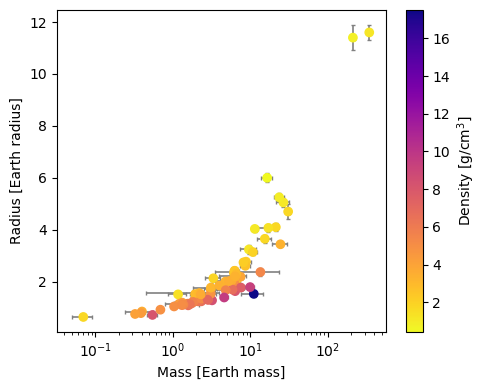

In [418]:
## Plot the mass and radius of small planets around M-dwarfs
plt.figure(figsize=(5,4))
plt.errorbar(M, R, xerr=err_M, yerr=err_R,
             linestyle='', fmt='o', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M, R, c=c, zorder=100, cmap='plasma_r')
plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.colorbar(label=r'Density [g/cm$^3$]')
plt.tight_layout()
plt.show()

Exoplaneteers made up cute names to describe planets in different compositions.
- "Rocky world" if a planet has a bulk density similar to the Earth.
- "Water world" if a planet has a bulk density consistent with 50% rocky and 50% water ice.
- "Puffy world" if a planet has a bulk density smaller than the "Water World" density.

Now, while it's possible that this final is making you wish you were on a "puff" of something or the other, we'll restrict our analysis to the rocky and water worlds. It's where the grant dollars are. 


### 3a - modeling the mass radius relation for rocky worlds (11 pts) 

First, select the rocky worlds. 

Let's write down the mass-radius relation for rocky worlds as a power law.

$R = aM^b$, where $a$ is proportional to $1/\rho_{\oplus}$, and $b$ is unitless. If the relation follows $M = \frac{4}{3}\pi R^3 \rho$, we have $a = 1$ and $b = 1/3$. However, in reality, the interior density of planets is not uniform and depends on the equation of state.

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

Hints:
- As a, b have to be positive, I'd suggest Uniform priors on log a, log b, and then using pm.Deterministic to exponentiate them 
- For the masses, since you've selected the rocky worlds, I'd suggest a normal distribution with the sample mean and sample standard deviation of the rocky worlds. 
- Given M, a, b you can use pm.Deterministic to get R_model
- Assume our favorite normal likelihood for R_model. You have the observed radius and their uncertainties from the file.

In [471]:
#Get rocky worlds only
#The Earth has a density ~5.5 g/cm^3
mask = (c < 7) & (c > 4)

M_rock = np.array(M[mask])
R_rock = np.array(R[mask])
M_err_rock = np.array(err_M[mask])
R_err_rock = np.array(err_R[mask])
c_rock = np.array(c[mask])

In [476]:
#Make pyMC model
import pymc as pm


with pm.Model() as model:
    #Priors
    loga = pm.Uniform('loga', lower=-1, upper=2)
    logb = pm.Uniform('logb', lower=-2, upper=2)
    
    a = pm.Deterministic('a', 10**loga)
    b = pm.Deterministic('b', 10**logb)
    
    #Expected value
    R_model = pm.Deterministic('R_model', a*(M_rock**b))
    
    #Likelihood
    likelihood = pm.Normal('likelihood', mu=R_model, sigma=R_err_rock, observed=R_rock)
    
    samples = pm.sample(10000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loga, logb]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


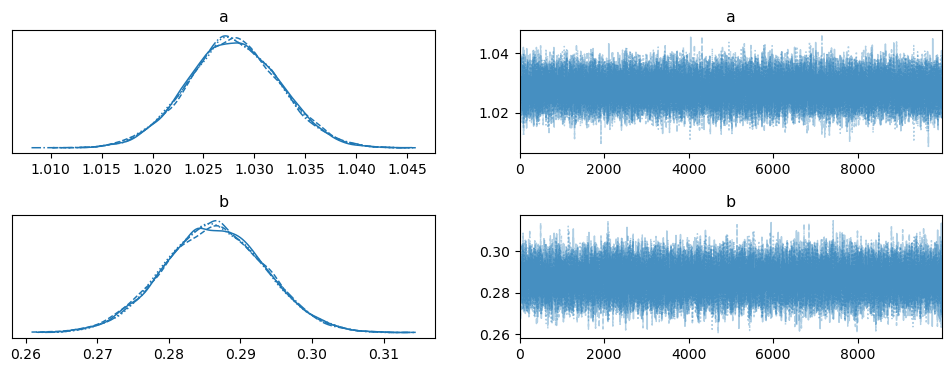

In [477]:
pm.plot_trace(samples.posterior[['a', 'b']], compact=True);
plt.subplots_adjust(hspace=.5)
plt.show()

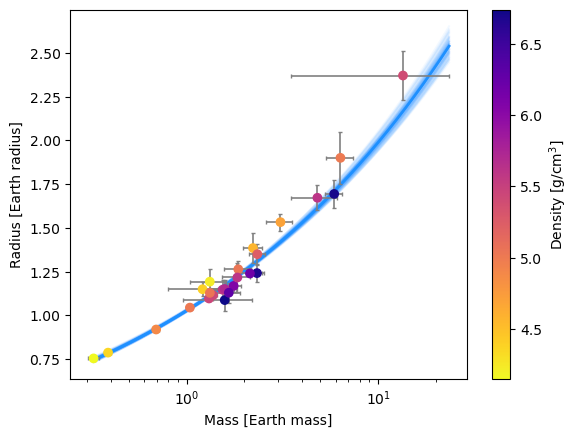

In [479]:
m_test = np.linspace( np.min(M_rock), np.max(M_rock)+10, 1000 )

a_samp = np.array(samples.posterior['a']).flatten()
b_samp = np.array(samples.posterior['b']).flatten()
r_samp = a_samp[:,None]*(m_test**b_samp[:,None])

a_med = np.median(samples.posterior['a'])
b_med = np.median(samples.posterior['b'])
r_test = a_med*(m_test**b_med)

for i in range(0, len(r_samp), 500):
    plt.plot(m_test, r_samp[i], color='DodgerBlue', alpha=.05)
    

plt.plot(m_test, r_test, color='DodgerBlue', lw=2)
plt.errorbar(M_rock, R_rock, xerr=M_err_rock, yerr=R_err_rock, fmt='.', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M_rock, R_rock, c=c_rock, zorder=100, cmap='plasma_r')

plt.colorbar(label=r'Density [g/cm$^3$]')

plt.xscale('log')
plt.xlabel('Mass [Earth mass]')
plt.ylabel('Radius [Earth radius]')
plt.show()

In [480]:
pm.summary(samples.posterior[['a', 'b']])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.028,0.005,1.020,1.037,0.0,0.0,39348.0,29530.0,1.0
b,0.286,0.007,0.273,0.300,0.0,0.0,38990.0,29867.0,1.0


### 3b - The Mass-Radius Relation for Rocky+Water Worlds (23 pts) 

Let's now add water worlds and model the mass-radius relation for both rocky and water worlds. Physically, it will require two models to describe the mass-radius relations for rocky and water worlds. The tricky part is we don't know exactly which kind of worlds a planet is belong to. In this situation, it is helpful to introduce a categorical variable `z` that is either 0 or 1, with the relative posterior probabilities telling us how Rocky/Watery a planet is.

Select the Rocky Water worlds - see the categories above 3a again. 

To make this work like magic with PyMC and it's Monte-Carlo sampler, we can choose a special prior for our categorial variable: the Drichlet Prior - https://en.wikipedia.org/wiki/Dirichlet_distribution

    # Two categories for water and rocky worlds
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(RockyWaterWorlds))
    

The rest of the PyMC model should be the same as 3a except you are fitting two relations - one for rocky worlds and one for water worlds, so you need two different `a` and `b` parameters - `shape=2` as above should take it. You might want to sort the `a` parameter with `transform=pm.distributions.transforms.ordered` when you define the prior to sort things. 

Build a PyMC model to find parameters of interest {a, b}. Plot the traces (`pm` has a `plot_trace` function)and inferred model, along with some draws.

In [481]:
#Select rocky and water worlds
#Rocky worlds have 4 < c < 7
#Water worlds have c ~ 3.2
mask = (c < 7) & (c > 2)

M_rw = np.array(M[mask])
R_rw = np.array(R[mask])
M_err_rw = np.array(err_M[mask])
R_err_rw = np.array(err_R[mask])
c_rw = np.array(c[mask])

In [482]:
M_py = np.vstack([M_rw, M_rw]).T
R_py = np.vstack([R_rw, R_rw]).T
R_err_py = np.vstack([R_err_rw, R_err_rw]).T

In [483]:
with pm.Model() as model:
    R_dat = pm.Data('R_dat', R_py)
    R_dat_err = pm.Data('R_dat_err', R_err_py)
    M_dat = pm.Data('M_dat', M_rw)
    
    p = pm.Dirichlet("p", a=np.ones(2), shape=2)
    z = pm.Categorical("z", p=p, shape=len(M_rw))

    
    #Priors
    loga = pm.Uniform('loga', lower=-1, upper=2, shape=2)
    logb = pm.Uniform('logb', lower=-2, upper=2, shape=2)

    a = pm.Deterministic('a', 10**loga)
    b = pm.Deterministic('b', 10**logb)
    


    #Expected value
    R_model1 = pm.Deterministic( 'R_model1', a[0]*( (M_dat*z)**b[0] ) )
    R_model2 = pm.Deterministic( 'R_model2', a[1]*( (M_dat*(1-z))**b[1] ) )
    
    #Combine models
    R_model = pm.math.stack([R_model1, R_model2], axis=1)

    
    #Likelihood
    likelihood = pm.Normal('likelihood', mu=R_model, sigma=R_dat_err, observed=R_dat)
    
    samples_rw = pm.sample(10000)

/Users/stoz1/anaconda3/envs/fds2/lib/python3.11/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, loga, logb]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
/Users/stoz1/anaconda3/envs/fds2/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


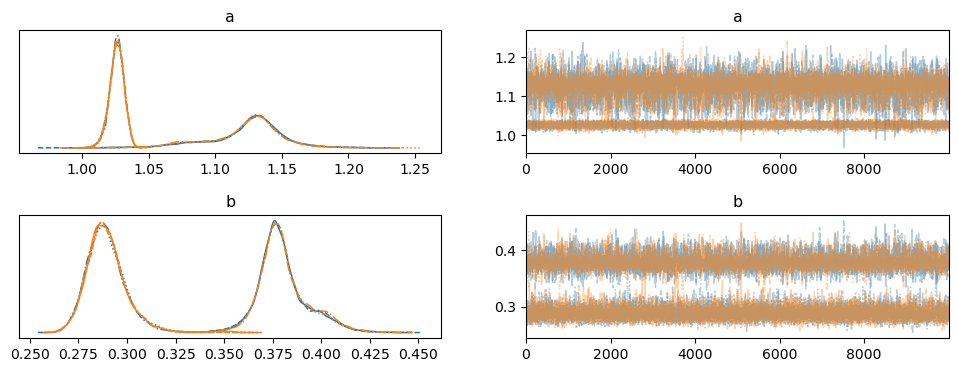

In [484]:
pm.plot_trace(samples_rw.posterior[['a', 'b']], compact=True);
plt.subplots_adjust(hspace=.5)
plt.show()

The chains for each population are mixed together, so we need to separate them:

In [485]:
z_samps = samples_rw.posterior['z'].data.reshape(-1, len(M_rw))
a_samps = samples_rw.posterior['a'].data.reshape(-1, 2)
b_samps = samples_rw.posterior['b'].data.reshape(-1, 2)

In [486]:
a0_samps = []
a1_samps = []

b0_samps = []
b1_samps = []

for i in range(len(a_samps)):
    
    if a_samps[i,0] > a_samps[i,1]:
        a1_samps.append(a_samps[i,0])
        a0_samps.append(a_samps[i,1])
        
        b1_samps.append(b_samps[i,0])
        b0_samps.append(b_samps[i,1])
    else:
        a1_samps.append(a_samps[i,1])
        a0_samps.append(a_samps[i,0])
        
        b1_samps.append(b_samps[i,1])
        b0_samps.append(b_samps[i,0])
        

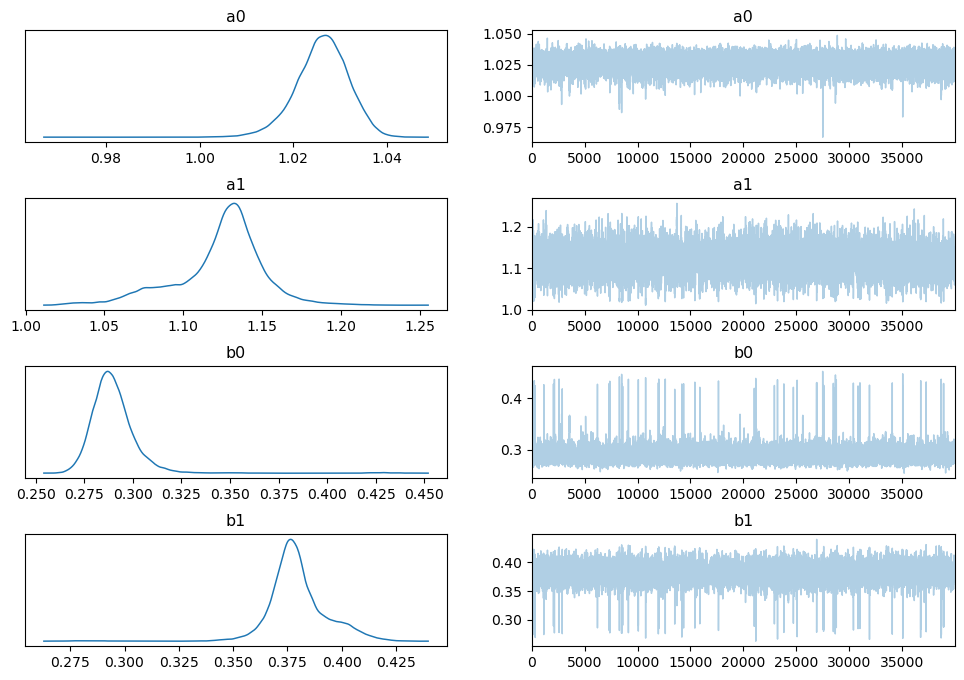

In [487]:
pm.plot_trace({'a0':a0_samps, 'a1':a1_samps, 'b0':b0_samps, 'b1':b1_samps}, compact=True);
plt.subplots_adjust(hspace=.5)
plt.show()

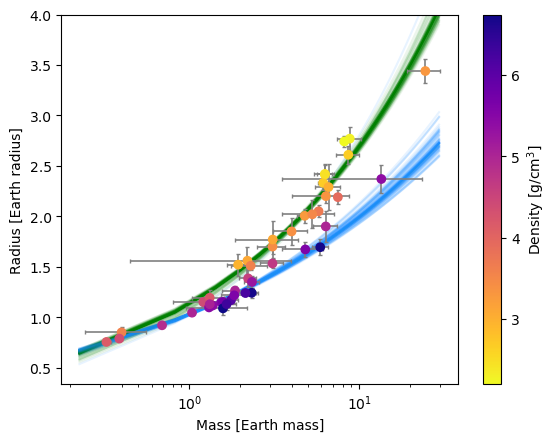

In [488]:
m_test2 = np.linspace( M_rw.min()-.1, M_rw.max()+5 )

a0_med_rw = np.median(a0_samps) 
a1_med_rw = np.median(a1_samps)
b0_med_rw = np.median(b0_samps)
b1_med_rw = np.median(b1_samps)


plt.plot(m_test2, a0_med_rw*(m_test2**b0_med_rw), color='DodgerBlue')
plt.plot(m_test2, a1_med_rw*(m_test2**b1_med_rw), color='g')
for i in range(0, len(a_samps), 500):
    plt.plot(m_test2, a0_samps[i]*(m_test2**b0_samps[i]), color='DodgerBlue', alpha=.1)
    plt.plot(m_test2, a1_samps[i]*(m_test2**b1_samps[i]), color='g', alpha=.075)


plt.errorbar(M_rw, R_rw, xerr=M_err_rw, yerr=R_err_rw, fmt='.', markersize=4, elinewidth=1.2, capsize=1.2, c='grey')
plt.scatter(M_rw, R_rw, c=c_rw, zorder=100, cmap='plasma_r')

plt.colorbar(label=r'Density [g/cm$^3$]')
plt.xscale('log')

plt.ylim(top=4)
plt.ylabel('Radius [Earth radius]')
plt.xlabel('Mass [Earth mass]')

plt.show()

In [489]:
pm.summary({'a0':a0_samps, 'a1':a1_samps, 'b0':b0_samps, 'b1':b1_samps})

arviz - WARNING - Shape validation failed: input_shape: (1, 40000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a0,1.026,0.006,1.016,1.036,0.0,0.0,13159.0,8439.0,NaN
a1,1.123,0.028,1.062,1.170,0.0,0.0,5637.0,6118.0,NaN
b0,0.290,0.014,0.271,0.310,0.0,0.0,10217.0,5933.0,NaN
b1,0.380,0.014,0.358,0.408,0.0,0.0,7368.0,8316.0,NaN


### Throughout, make sure your plots have things like appropriate axes scales, axes labels, errorsbars, legends, reasonable colors. Remember, these are how you tell the story of what you've done, and ultimately what we're looking at.  


### Get started. You know how to do all of this. If not, there's something in a class notebook that can help. I'm on Teams, so direct questions there. 

# Best of luck. You've got this. 